Target:

 Add Batch-norm to increase model efficiency.

Results:



*   Parameters: 5,088
*   Best Train Accuracy: 99.02%
*   Best Test Accuracy: 99.03%

Analysis:


*   There is slight increase in the number of parameters, as batch norm stores a specific mean and std deviation for each layer.
*   Model overfitting problem is rectified to an extent. But, we have not reached the target test accuracy 99.40%.




# Import Libraries

Let's first import all the necessary libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

# Defining Model
 Create a CNN Model Skeleton

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()


        #Input Block
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 8, 3,padding=0,bias=False),  # 28x28 output 28x28 RF : 3x3
            nn.BatchNorm2d(8),
            nn.ReLU(),

            nn.Conv2d(8, 16, 3,padding=0,bias=False), # 28x28 output 28x28 RF : 5x5
            nn.BatchNorm2d(16),
            nn.ReLU(),

                    
        )

        #Transition Block (MaxPool + 1x1)
        self.trans1 = nn.Sequential(
            nn.MaxPool2d(2, 2),
            # 1x1 convolution
            nn.Conv2d(16, 8, 1,bias=False), # 26x26 output - 26x26 RF 14x14
            nn.BatchNorm2d(8),
            nn.ReLU(),

              # 26x26 output - 13x13 RF 14x14

        )

        #CONVOLUTION BLOCK 2
        self.conv2 =  nn.Sequential(

            nn.Conv2d(8, 10, 3,padding=0, bias=False), # 13x13 output - 11x11 RF 16x16
            nn.BatchNorm2d(10),
            nn.ReLU(),

            nn.Conv2d(10, 16, 3,padding=0, bias=False),  # 11x11 output - 9x9 RF 18x18
            nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.Conv2d(16, 10, 3,padding=0, bias=False), # 9x9 output - 7x7 RF 20x20
            nn.BatchNorm2d(10),
            nn.ReLU(),

            
            
        )
        self.avgpool2d = nn.AvgPool2d(kernel_size=6)

        

    def forward(self, x):
        x = self.conv1(x)
        x = self.trans1(x)
        x = self.conv2(x)
        x = self.avgpool2d(x)
        x = x.view(-1,10)

        return F.log_softmax(x,dim=1)

# Model Summary
 To view and to understand Model Trainable parameteres

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
            Conv2d-4           [-1, 16, 24, 24]           1,152
       BatchNorm2d-5           [-1, 16, 24, 24]              32
              ReLU-6           [-1, 16, 24, 24]               0
         MaxPool2d-7           [-1, 16, 12, 12]               0
            Conv2d-8            [-1, 8, 12, 12]             128
       BatchNorm2d-9            [-1, 8, 12, 12]              16
             ReLU-10            [-1, 8, 12, 12]               0
           Conv2d-11           [-1, 10, 10, 10]             720
      BatchNorm2d-12           [-1, 10, 10, 10]              20
             ReLU-13           [-1, 10, 10, 10]               0
           Conv2d-14             [-1, 1

# The Model


In [ ]:
model.eval()

Net(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (trans1): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(8, 10, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, tr

## Load and Prepare Dataset

MNIST contains 70,000 images of handwritten digits: 60,000 for training and 10,000 for testing. The images are grayscale, 28x28 pixels

We load the PIL images using torchvision.datasets.MNIST, while loading the image we transform he data to tensor and normalize the images with mean and std deviation of MNIST images.

In [ ]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train = datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ]))

test = datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ]))
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False, **kwargs)


Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Training & Testing Functions
 Creating Training and Testing functions.

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Train & Test our Model
 Let's train and test our model

In [ ]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.2373165637254715 Batch_id=468 Accuracy=89.39: 100%|██████████| 469/469 [00:11<00:00, 40.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2291, Accuracy: 9551/10000 (95.51%)

EPOCH: 1


Loss=0.13370917737483978 Batch_id=468 Accuracy=97.18: 100%|██████████| 469/469 [00:11<00:00, 40.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1294, Accuracy: 9757/10000 (97.57%)

EPOCH: 2


Loss=0.10749738663434982 Batch_id=468 Accuracy=97.80: 100%|██████████| 469/469 [00:11<00:00, 40.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0927, Accuracy: 9831/10000 (98.31%)

EPOCH: 3


Loss=0.0826670303940773 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:11<00:00, 40.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0837, Accuracy: 9828/10000 (98.28%)

EPOCH: 4


Loss=0.049869354814291 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:11<00:00, 41.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0983, Accuracy: 9758/10000 (97.58%)

EPOCH: 5


Loss=0.015410483814775944 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:11<00:00, 40.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0638, Accuracy: 9839/10000 (98.39%)

EPOCH: 6


Loss=0.09547046571969986 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:11<00:00, 41.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0729, Accuracy: 9832/10000 (98.32%)

EPOCH: 7


Loss=0.09048176556825638 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:11<00:00, 40.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0537, Accuracy: 9871/10000 (98.71%)

EPOCH: 8


Loss=0.04281114414334297 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:11<00:00, 41.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0548, Accuracy: 9862/10000 (98.62%)

EPOCH: 9


Loss=0.0530521422624588 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:11<00:00, 40.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0522, Accuracy: 9868/10000 (98.68%)

EPOCH: 10


Loss=0.06441278755664825 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:11<00:00, 40.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0541, Accuracy: 9856/10000 (98.56%)

EPOCH: 11


Loss=0.09128996729850769 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:11<00:00, 41.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0483, Accuracy: 9884/10000 (98.84%)

EPOCH: 12


Loss=0.03341076523065567 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:11<00:00, 41.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0448, Accuracy: 9888/10000 (98.88%)

EPOCH: 13


Loss=0.0869518294930458 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:11<00:00, 39.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0420, Accuracy: 9888/10000 (98.88%)

EPOCH: 14


Loss=0.0659508928656578 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:11<00:00, 40.18it/s]



Test set: Average loss: 0.0397, Accuracy: 9903/10000 (99.03%)



# Observation


Text(0.5, 1.0, 'Test Accuracy')

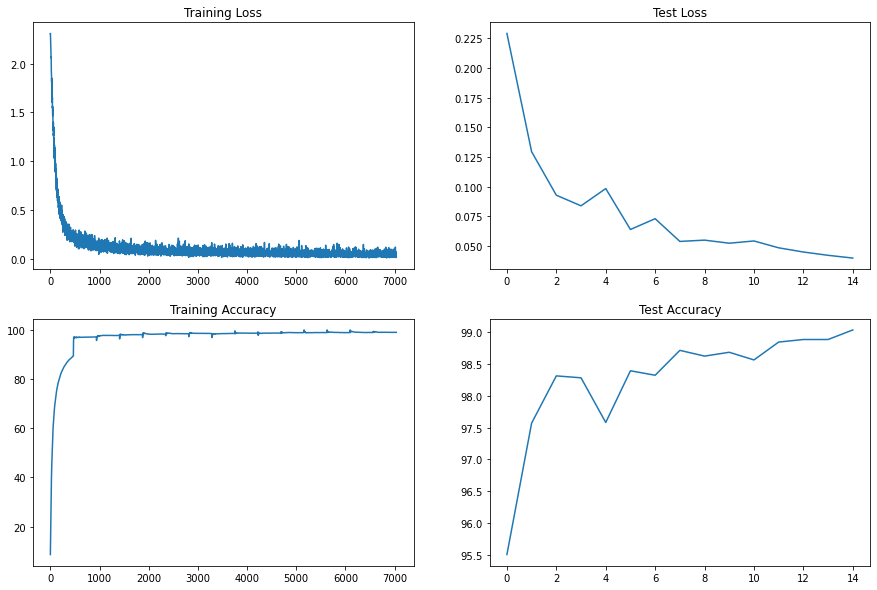

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")